# Deep Learning (CSE641) Project
### Team [Aadit Jha](mailto:aadit20001@iiitd.ac.in), [Niranjan S](mailto:niranjan20090@iiitd.ac.in), [Sahas Marwah](mailto:sahas20237@iiitd.ac.in) from IIIT-Delhi

### Part 1 --- Implementation of __baselines__ for the task of __beat and downbeat estimation__ using deep neural architectures.

### Baseline 2 --- Implementation of BeatNet Model [[Heydari et. al ISMIR 2021]](https://arxiv.org/pdf/2108.03576.pdf) using DBN post-processor from [[Bock et. al ISMIR 2016]](https://wp.nyu.edu/ismir2016/wp-content/uploads/sites/2294/2016/07/186_Paper.pdf) for offline inference (our task).

In [1]:
%%writefile input
y

Writing input


In [2]:
#Installing dependencies for PyAudio
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg < input

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.2.2-2.1ubuntu2.5).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 188 kB of archives.
After this operation, 926 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudiocpp0 amd64 19.6.0-1build1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 portaudio19-dev amd64 19.6.0-1build1 [106 kB]
Fetched 188 kB in 1s (263 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 128276 files and directories currently installe

In [3]:
#Installing Relevant Packages
!pip install mirdata
!pip install madmom
!pip install pyaudio
!pip install BeatNet --no-deps
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 98.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=1d3e153c79b2b48d53f58e029c86b0be0e300a653f810331a6de5eedf4022172
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64923 sha256=7b209baee358099fe2ecefc9e2

## Setup

In [12]:
import os
import mirdata
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import random
import numpy as np
import librosa
import madmom
import pyaudio
from tqdm import tqdm as tqdm
import torchmetrics
import warnings

In [5]:
# ignore certain warnings
warnings.filterwarnings('ignore')

# set default figure size
plt.rcParams['figure.figsize'] = (20, 6)

In [6]:
#Ensure deterministic behaviour
torch.backends.cudnn.deterministic = True
random.seed(hash("Setting random hash") % 2**32 - 1)
torch.manual_seed(hash("By removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("So runs are repeatable") % 2**32 - 1)
np.random.seed(hash("Improves reducibility") % 2**32 - 1)

In [7]:
working_dir = '/content/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device:',device)

Device: cuda:0


In [8]:
#Unzipping data.zip
import os
import zipfile

with zipfile.ZipFile('data.zip','r') as zip:
    zip.extractall(working_dir)

In [9]:
working_dir = os.path.join(working_dir,'data')

In [10]:
sample_rate = 22050
log_spec_sample_rate = sample_rate
log_spec_hop_length = int(20 * 0.001 * log_spec_sample_rate)
log_spec_win_length = int(64 * 0.001 * log_spec_sample_rate)

config = dict(
    sample_rate = sample_rate,
    log_spec_sample_rate = log_spec_sample_rate,
    log_spec_hop_length = log_spec_hop_length,
    log_spec_win_length = log_spec_win_length,
    mode = 'offline',
    FPS = 50,    
)

### **GTZAN Dataset**
#### Mini Version

In [13]:
#Small Dataset
gtzan = mirdata.initialize('gtzan_genre', version='mini',data_home=os.path.join(working_dir,'dataset'))
gtzan.download()
print(len(gtzan.track_ids))

track_ids = gtzan.track_ids
print(gtzan.track(track_ids[42]))

118MB [00:07, 16.5MB/s]
632kB [00:00, 1.40MB/s] 


100
Track(
  audio_path="/content/data/dataset/gtzan_mini-main/genres/jazz/jazz.00002.wav",
  beats_path="/content/data/dataset/gtzan_tempo_beat-main/beats/gtzan_jazz_00002.beats",
  genre="jazz",
  tempo_path="/content/data/dataset/gtzan_tempo_beat-main/tempo/gtzan_jazz_00002.bpm",
  track_id="jazz.00002",
  audio: The track's audio

        Returns,
  beats: ,
  tempo: ,
)


#### Full Version

In [14]:
!pip install gdown
!mkdir -p /root/mir_datasets/gtzan_genre/gtzan_genre/
!gdown --id 1cwb2vAKryAYqkP2D86bpO6mbVlQmVhjN --output /root/mir_datasets/gtzan_genre/gtzan_genre/genres.tar.gz
# use the following line to initialise the dataset (i.e. the full version without 'mini')
gtzan = mirdata.initialize('gtzan_genre')
gtzan.download()
print(len(gtzan.track_ids))

track_ids = gtzan.track_ids
print(gtzan.track(track_ids[42]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cwb2vAKryAYqkP2D86bpO6mbVlQmVhjN
To: /root/mir_datasets/gtzan_genre/gtzan_genre/genres.tar.gz
100% 1.23G/1.23G [00:13<00:00, 91.3MB/s]


632kB [00:00, 2.69MB/s] 


1000
Track(
  audio_path="/root/mir_datasets/gtzan_genre/gtzan_genre/genres/classical/classical.00042.wav",
  beats_path="/root/mir_datasets/gtzan_genre/gtzan_tempo_beat-main/beats/gtzan_classical_00042.beats",
  genre="classical",
  tempo_path="/root/mir_datasets/gtzan_genre/gtzan_tempo_beat-main/tempo/gtzan_classical_00042.bpm",
  track_id="classical.00042",
  audio: The track's audio

        Returns,
  beats: ,
  tempo: ,
)


#### **Creating Splits (70%,15%,15%)**

In [15]:
from sklearn.model_selection import train_test_split

tracks = gtzan.load_tracks()
train_files, test_files = train_test_split(list(tracks.keys()), test_size=0.3, random_state=1234)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=1234)
len(train_files), len(val_files), len(test_files)

(700, 150, 150)

### **BeatNet's Logarithmic Spectrogram Preprocessor**

In [16]:
from BeatNet.BeatNet import BeatNet
from BeatNet.log_spect import LOG_SPECT

#BeatNet's Pre-processor that extracts magnitude spectrogoram and its differences
preprocessor = LOG_SPECT(sample_rate=config['log_spec_sample_rate'], win_length=config['log_spec_win_length'],
                             hop_size=config['log_spec_hop_length'], n_bands=[24], mode = config['mode'])

### **GTZAN Dataset Class**

In [17]:
from torch.utils.data import Dataset
class GtzanDataset(Dataset):
    def __init__(self,gtzan,track_ids,preprocessor,device,sample_rate,fps):
        self.device = device
        self.sample_rate = sample_rate
        self.fps = fps
        self.duration =29
        self.feats = []
        self.tracks = []
        self.track_ids = []
        for track_id in tqdm(track_ids,desc='Preprocessing...',ncols=75):
            track = gtzan.track(track_id)
            audio, _ = librosa.load(track.audio_path, sr=self.sample_rate)
            try:
                beats = track.beats.times
                downbeats = track.beats.positions.astype(int) == 1
            except AttributeError:
                continue
            self.tracks.append(track)
            self.feats.append(preprocessor.process_audio(audio).T)
            self.track_ids.append(track_id)
                
    def __len__(self):
        return len(self.tracks)
    
    def __getitem__(self,idx):
        track = self.tracks[idx]
        feats = self.feats[idx]
        track_id = self.track_ids[idx]
        beats = track.beats.times
        downbeats = track.beats.positions.astype(int) == 1
        downbeats = track.beats.times[downbeats]
        
        beats = track.beats.times[track.beats.positions.astype(int) != 1] #CE
        
        beats = madmom.utils.quantize_events(beats,fps=self.fps,length=len(feats))
        downbeats = madmom.utils.quantize_events(downbeats,fps=self.fps,length=len(feats))
        nonbeats = (beats == 0)&(downbeats == 0)
                
        beats = beats.reshape(beats.shape[0],1)
        downbeats = downbeats.reshape(downbeats.shape[0],1)
        nonbeats = nonbeats.reshape(nonbeats.shape[0],1)
        
        truths = np.hstack([beats,downbeats,nonbeats])
        
        feats = torch.from_numpy(feats).to(device).type(torch.FloatTensor)
        truths = torch.from_numpy(truths).to(device).type(torch.FloatTensor)       

        return feats[:self.duration*self.fps], truths[:self.duration*self.fps], track_id

In [18]:
# Uncomment if you want to train the network
# train_dataset = GtzanDataset(gtzan=gtzan,track_ids=train_files,preprocessor=preprocessor,device=device,
#                              sample_rate=config['sample_rate'],fps=config['FPS'])
# val_dataset = GtzanDataset(gtzan=gtzan,track_ids=val_files,preprocessor=preprocessor,device=device,
#                            sample_rate=config['sample_rate'],fps=config['FPS'])
test_dataset = GtzanDataset(gtzan=gtzan,track_ids=test_files,preprocessor=preprocessor,device=device,
                            sample_rate=config['sample_rate'],fps=config['FPS'])

Preprocessing...: 100%|██████████████████| 150/150 [00:25<00:00,  5.95it/s]


In [19]:
#len(train_dataset),len(test_dataset),len(val_dataset)

(694, 149, 150)

### **BeatNet Model**

In [20]:
config['batch_size'] = 5

from BeatNet.model import BDA

#BeatNet's Beat-Downbeat activation model
model = BDA(272,150,2,device)

model.hidden = torch.zeros(2, config['batch_size'], 150).to(device)
model.cell = torch.zeros(2, config['batch_size'], 150).to(device)


print('BeatNet Model:',model)

BeatNet Model: BDA(
  (conv1): Conv1d(1, 2, kernel_size=(10,), stride=(1,))
  (linear0): Linear(in_features=262, out_features=150, bias=True)
  (lstm): LSTM(150, 150, num_layers=2, batch_first=True)
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (softmax): Softmax(dim=0)
)


### **Weighted Cross Entropy Loss**

In [21]:
class WeightedCELoss(torch.nn.Module):
    def __init__(self):
        super(WeightedCELoss, self).__init__()

    def forward(self, input, target):
        
        #Computing Class Frequency
        class_freqs = torch.sum(target, dim=(0, 1)) / (input.shape[0] * input.shape[1])
        weights = 1.0 / class_freqs
        #Normalizing Weights
        weights /= torch.sum(weights)
#         loss = nn.CrossEntropyLoss()(input.permute(0,2,1), target.permute(0,2,1))
        loss = nn.CrossEntropyLoss(weight=weights)(input.permute(0,2,1), target.permute(0,2,1))
        return loss

In [22]:
config['learning_rate'] = 5e-4
config['loss'] = WeightedCELoss()
config['metrics'] = {
#     'MulticlassAccuracy':torchmetrics.classification.MulticlassAccuracy(3,average='none'),
    'MultilabelF1Score':torchmetrics.classification.MultilabelF1Score(3,average='none')
}
config['optimizer'] = torch.optim.Adam(model.parameters(),lr=config['learning_rate'])
config['epochs'] = 10
config['patience'] = 20

In [23]:
#Uncomment if you want to train the network.
from torch.utils.data import DataLoader
#train_loader = DataLoader(dataset=train_dataset,batch_size=config['batch_size'],shuffle=True,drop_last=True)
#val_loader = DataLoader(dataset=val_dataset,batch_size=config['batch_size'],shuffle=False,drop_last=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=config['batch_size'],shuffle=False,drop_last=True)

In [24]:
def test(model,test_loader,config):
    metric_funs = config['metrics']
    sftmax = nn.Softmax(dim=1)
    
    loss_fun = config['loss']
    for metric in metric_funs:
        metric_funs[metric].reset()
    
    model.eval()
    running_loss = 0
    for metric in metric_funs:
        metric_funs[metric].reset()

    with torch.no_grad():
        for i, (tracks,truths,_) in enumerate(test_loader):
            tracks = tracks.to(device)
            truths = truths.to(device)

            output = model(tracks).permute(0,2,1)

            running_loss += loss_fun(output,truths).detach().cpu().item()

            op = output.detach().cpu().permute(0,2,1)
            tr = truths.detach().cpu().permute(0,2,1)
            
            for metric in metric_funs:
                metric_funs[metric].update(op,tr)
                
    
    loss = running_loss/len(test_loader)
    metrics = {}
    for metric in metric_funs:
        metrics[metric] = metric_funs[metric].compute()
        
    return loss,metrics

In [25]:
def train(model,train_loader,val_loader,config):
    running_loss = 0
    epochs = config['epochs']
    loss_fun = config['loss']
    optimizer = config['optimizer']
    batch_size = config['batch_size']
    metric_funs = config['metrics']
    PATH = config['PATH']
    
    sftmax = nn.Softmax(dim=1)
    
    best_val_loss = None
    best_model = None
    best_val_loss_epoch = -1
    
    for e in range(epochs):
        model.train()
        running_loss = 0        
        
        for metric in metric_funs:
            metric_funs[metric].reset()
        
        for i, (tracks,truths,_) in tqdm(enumerate(train_loader),unit_scale=batch_size,total=len(train_loader),desc=f'Epoch: {e+1}/{epochs}',position=0,ncols=75):
            tracks = tracks.to(device)
            truths = truths.to(device)

            model.hidden = model.hidden.detach()
            model.cell = model.cell.detach()

            #3xF
            output = model(tracks).permute(0,2,1)

            loss = loss_fun(output,truths)
            
            op = output.detach().cpu().permute(0,2,1)
            tr = truths.detach().cpu().permute(0,2,1)
            
            
            for metric in metric_funs:
                metric_funs[metric].update(op,tr)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.detach().cpu().item()
        
        training_loss = running_loss/len(train_loader)
        training_metrics = {}
        for metric in metric_funs:
            training_metrics[metric] = metric_funs[metric].compute()
        
        #Validation
        validation_loss, validation_metrics = test(model,val_loader,config)
        
        print(f'Training Loss: {training_loss :.5f} | Validation Loss: {validation_loss :.5f}')
        print('Training Metrics: ',end='')
        for training_metric in training_metrics:
            print(f'{training_metric} : {training_metrics[training_metric]}',end=' ')
        print('\nValidation Metrics: ',end='')
        for validation_metric in validation_metrics:
            print(f'{validation_metric} : {validation_metrics[validation_metric]}',end=' ')
        print()
        
        if best_val_loss is None or best_val_loss > validation_loss:
            print('Model Updated')
            best_val_loss = validation_loss
            best_val_loss_epoch = e
            best_model = model
            
        print('-'*100)
            
        if abs(e-best_val_loss_epoch) >= config['patience']:
            print('Early Stopping...')
            break
    
    torch.save(model.state_dict(), PATH)
    return best_model

### **Training the model**
For 100 epochs, with validation and a patience of 20 epochs. Optimizer is Adam with 5x10<sup>4</sup> learning rate and Weighted Cross Entropy Loss.

In [ ]:
# Uncomment if you want to train the network
# config['PATH'] = os.path.join(working_dir,'models/beatnet_gtzan_full_attempt_2.pth')
# config['epochs'] = 100
# model = train(model,train_loader,val_loader,config)

Epoch: 1/100: 100%|██████████████████████| 690/690 [00:17<00:00, 38.98it/s]


Training Loss: 0.16025 | Validation Loss: 0.14304
Training Metrics: MultilabelF1Score : tensor([0.2436, 0.0140, 0.9790]) 
Validation Metrics: MultilabelF1Score : tensor([0.2677, 0.0000, 0.9799]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 2/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.25it/s]


Training Loss: 0.14077 | Validation Loss: 0.13876
Training Metrics: MultilabelF1Score : tensor([0.3044, 0.0000, 0.9797]) 
Validation Metrics: MultilabelF1Score : tensor([0.2381, 0.0000, 0.9800]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 3/100: 100%|██████████████████████| 690/690 [00:17<00:00, 38.82it/s]


Training Loss: 0.13741 | Validation Loss: 0.13582
Training Metrics: MultilabelF1Score : tensor([3.1644e-01, 3.9212e-04, 9.7995e-01]) 
Validation Metrics: MultilabelF1Score : tensor([0.2921, 0.0000, 0.9801]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 4/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.02it/s]


Training Loss: 0.13612 | Validation Loss: 0.13513
Training Metrics: MultilabelF1Score : tensor([0.3303, 0.0014, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.2950, 0.0045, 0.9803]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 5/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.21it/s]


Training Loss: 0.13389 | Validation Loss: 0.13466
Training Metrics: MultilabelF1Score : tensor([0.3383, 0.0049, 0.9801]) 
Validation Metrics: MultilabelF1Score : tensor([0.2763, 0.0350, 0.9805]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 6/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.19it/s]


Training Loss: 0.13277 | Validation Loss: 0.13427
Training Metrics: MultilabelF1Score : tensor([0.3384, 0.0093, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3268, 0.0064, 0.9807]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 7/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.21it/s]


Training Loss: 0.13226 | Validation Loss: 0.13249
Training Metrics: MultilabelF1Score : tensor([0.3434, 0.0106, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3354, 0.0027, 0.9804]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 8/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.09it/s]


Training Loss: 0.13141 | Validation Loss: 0.13198
Training Metrics: MultilabelF1Score : tensor([0.3510, 0.0313, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3282, 0.0054, 0.9804]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 9/100: 100%|██████████████████████| 690/690 [00:17<00:00, 39.09it/s]


Training Loss: 0.13039 | Validation Loss: 0.13174
Training Metrics: MultilabelF1Score : tensor([0.3516, 0.0429, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3427, 0.0584, 0.9805]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 10/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.30it/s]


Training Loss: 0.12934 | Validation Loss: 0.12959
Training Metrics: MultilabelF1Score : tensor([0.3577, 0.0682, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3402, 0.0411, 0.9805]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 11/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.15it/s]


Training Loss: 0.12817 | Validation Loss: 0.13079
Training Metrics: MultilabelF1Score : tensor([0.3594, 0.0805, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3324, 0.1173, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 12/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.21it/s]


Training Loss: 0.12749 | Validation Loss: 0.12920
Training Metrics: MultilabelF1Score : tensor([0.3601, 0.0950, 0.9801]) 
Validation Metrics: MultilabelF1Score : tensor([0.3286, 0.0135, 0.9801]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 13/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.17it/s]


Training Loss: 0.13458 | Validation Loss: 0.13798
Training Metrics: MultilabelF1Score : tensor([0.3268, 0.0549, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.2631, 0.0000, 0.9800]) 
----------------------------------------------------------------------------------------------------


Epoch: 14/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.18it/s]


Training Loss: 0.13717 | Validation Loss: 0.13719
Training Metrics: MultilabelF1Score : tensor([0.3320, 0.0014, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3187, 0.0000, 0.9800]) 
----------------------------------------------------------------------------------------------------


Epoch: 15/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.17it/s]


Training Loss: 0.13449 | Validation Loss: 0.13356
Training Metrics: MultilabelF1Score : tensor([0.3517, 0.0020, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3410, 0.0018, 0.9801]) 
----------------------------------------------------------------------------------------------------


Epoch: 16/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.43it/s]


Training Loss: 0.13253 | Validation Loss: 0.13416
Training Metrics: MultilabelF1Score : tensor([0.3614, 0.0236, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3423, 0.0631, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 17/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.25it/s]


Training Loss: 0.13182 | Validation Loss: 0.13216
Training Metrics: MultilabelF1Score : tensor([0.3618, 0.0659, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3366, 0.0493, 0.9800]) 
----------------------------------------------------------------------------------------------------


Epoch: 18/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.00it/s]


Training Loss: 0.13069 | Validation Loss: 0.13156
Training Metrics: MultilabelF1Score : tensor([0.3646, 0.1039, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3386, 0.0939, 0.9800]) 
----------------------------------------------------------------------------------------------------


Epoch: 19/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.90it/s]


Training Loss: 0.12992 | Validation Loss: 0.13103
Training Metrics: MultilabelF1Score : tensor([0.3637, 0.1166, 0.9798]) 
Validation Metrics: MultilabelF1Score : tensor([0.3377, 0.1353, 0.9801]) 
----------------------------------------------------------------------------------------------------


Epoch: 20/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.27it/s]


Training Loss: 0.12864 | Validation Loss: 0.13053
Training Metrics: MultilabelF1Score : tensor([0.3687, 0.1383, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3530, 0.1434, 0.9801]) 
----------------------------------------------------------------------------------------------------


Epoch: 21/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.21it/s]


Training Loss: 0.12834 | Validation Loss: 0.12936
Training Metrics: MultilabelF1Score : tensor([0.3681, 0.1496, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3424, 0.1407, 0.9801]) 
----------------------------------------------------------------------------------------------------


Epoch: 22/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.26it/s]


Training Loss: 0.12697 | Validation Loss: 0.12894
Training Metrics: MultilabelF1Score : tensor([0.3729, 0.1577, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3449, 0.1709, 0.9803]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 23/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.16it/s]


Training Loss: 0.12664 | Validation Loss: 0.12953
Training Metrics: MultilabelF1Score : tensor([0.3699, 0.1795, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3466, 0.1349, 0.9802]) 
----------------------------------------------------------------------------------------------------


Epoch: 24/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.11it/s]


Training Loss: 0.12595 | Validation Loss: 0.12773
Training Metrics: MultilabelF1Score : tensor([0.3715, 0.1777, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3441, 0.1063, 0.9801]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 25/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.20it/s]


Training Loss: 0.12512 | Validation Loss: 0.13019
Training Metrics: MultilabelF1Score : tensor([0.3778, 0.1924, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3502, 0.2050, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 26/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.13it/s]


Training Loss: 0.12773 | Validation Loss: 0.12892
Training Metrics: MultilabelF1Score : tensor([0.3709, 0.1796, 0.9798]) 
Validation Metrics: MultilabelF1Score : tensor([0.3495, 0.1310, 0.9800]) 
----------------------------------------------------------------------------------------------------


Epoch: 27/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.27it/s]


Training Loss: 0.12564 | Validation Loss: 0.12730
Training Metrics: MultilabelF1Score : tensor([0.3758, 0.1973, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3495, 0.1549, 0.9801]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 28/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.14it/s]


Training Loss: 0.12514 | Validation Loss: 0.12735
Training Metrics: MultilabelF1Score : tensor([0.3759, 0.2091, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3477, 0.1698, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 29/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.87it/s]


Training Loss: 0.12374 | Validation Loss: 0.12790
Training Metrics: MultilabelF1Score : tensor([0.3777, 0.2144, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3665, 0.1623, 0.9802]) 
----------------------------------------------------------------------------------------------------


Epoch: 30/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.13it/s]


Training Loss: 0.12362 | Validation Loss: 0.13059
Training Metrics: MultilabelF1Score : tensor([0.3796, 0.2040, 0.9799]) 
Validation Metrics: MultilabelF1Score : tensor([0.3541, 0.1266, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 31/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.18it/s]


Training Loss: 0.12369 | Validation Loss: 0.12735
Training Metrics: MultilabelF1Score : tensor([0.3823, 0.2131, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3558, 0.2310, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 32/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.20it/s]


Training Loss: 0.12264 | Validation Loss: 0.12719
Training Metrics: MultilabelF1Score : tensor([0.3821, 0.2348, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3592, 0.1905, 0.9805]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 33/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.98it/s]


Training Loss: 0.12179 | Validation Loss: 0.13069
Training Metrics: MultilabelF1Score : tensor([0.3885, 0.2194, 0.9801]) 
Validation Metrics: MultilabelF1Score : tensor([0.3652, 0.2507, 0.9809]) 
----------------------------------------------------------------------------------------------------


Epoch: 34/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.13it/s]


Training Loss: 0.12151 | Validation Loss: 0.12824
Training Metrics: MultilabelF1Score : tensor([0.3886, 0.2176, 0.9801]) 
Validation Metrics: MultilabelF1Score : tensor([0.3508, 0.2212, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 35/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.28it/s]


Training Loss: 0.12025 | Validation Loss: 0.12709
Training Metrics: MultilabelF1Score : tensor([0.3919, 0.2369, 0.9801]) 
Validation Metrics: MultilabelF1Score : tensor([0.3653, 0.2057, 0.9804]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 36/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.12it/s]


Training Loss: 0.11979 | Validation Loss: 0.12750
Training Metrics: MultilabelF1Score : tensor([0.3960, 0.2352, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3574, 0.1918, 0.9801]) 
----------------------------------------------------------------------------------------------------


Epoch: 37/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.22it/s]


Training Loss: 0.12009 | Validation Loss: 0.12579
Training Metrics: MultilabelF1Score : tensor([0.3968, 0.2359, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3552, 0.0855, 0.9800]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 38/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.15it/s]


Training Loss: 0.11940 | Validation Loss: 0.12640
Training Metrics: MultilabelF1Score : tensor([0.3941, 0.2267, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3617, 0.2421, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 39/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.17it/s]


Training Loss: 0.11827 | Validation Loss: 0.12516
Training Metrics: MultilabelF1Score : tensor([0.3960, 0.2394, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3721, 0.1811, 0.9803]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 40/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.28it/s]


Training Loss: 0.11830 | Validation Loss: 0.12526
Training Metrics: MultilabelF1Score : tensor([0.4000, 0.2486, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3662, 0.1982, 0.9805]) 
----------------------------------------------------------------------------------------------------


Epoch: 41/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.48it/s]


Training Loss: 0.11868 | Validation Loss: 0.12639
Training Metrics: MultilabelF1Score : tensor([0.3956, 0.2394, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3541, 0.2129, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 42/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.26it/s]


Training Loss: 0.11792 | Validation Loss: 0.12648
Training Metrics: MultilabelF1Score : tensor([0.3998, 0.2342, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3653, 0.1626, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 43/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.22it/s]


Training Loss: 0.11710 | Validation Loss: 0.12594
Training Metrics: MultilabelF1Score : tensor([0.3978, 0.2484, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3672, 0.2111, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 44/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.04it/s]


Training Loss: 0.11532 | Validation Loss: 0.12569
Training Metrics: MultilabelF1Score : tensor([0.4117, 0.2479, 0.9805]) 
Validation Metrics: MultilabelF1Score : tensor([0.3629, 0.2343, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 45/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.10it/s]


Training Loss: 0.11473 | Validation Loss: 0.12624
Training Metrics: MultilabelF1Score : tensor([0.4095, 0.2544, 0.9805]) 
Validation Metrics: MultilabelF1Score : tensor([0.3651, 0.2281, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 46/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.21it/s]


Training Loss: 0.11491 | Validation Loss: 0.12717
Training Metrics: MultilabelF1Score : tensor([0.4084, 0.2584, 0.9804]) 
Validation Metrics: MultilabelF1Score : tensor([0.3664, 0.2405, 0.9807]) 
----------------------------------------------------------------------------------------------------


Epoch: 47/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.01it/s]


Training Loss: 0.11407 | Validation Loss: 0.12488
Training Metrics: MultilabelF1Score : tensor([0.4129, 0.2656, 0.9805]) 
Validation Metrics: MultilabelF1Score : tensor([0.3631, 0.2136, 0.9803]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 48/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.22it/s]


Training Loss: 0.11395 | Validation Loss: 0.12351
Training Metrics: MultilabelF1Score : tensor([0.4118, 0.2691, 0.9804]) 
Validation Metrics: MultilabelF1Score : tensor([0.3728, 0.1885, 0.9804]) 
Model Updated
----------------------------------------------------------------------------------------------------


Epoch: 49/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.29it/s]


Training Loss: 0.12075 | Validation Loss: 0.12638
Training Metrics: MultilabelF1Score : tensor([0.3915, 0.2267, 0.9802]) 
Validation Metrics: MultilabelF1Score : tensor([0.3596, 0.2258, 0.9804]) 
----------------------------------------------------------------------------------------------------


Epoch: 50/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.35it/s]


Training Loss: 0.12273 | Validation Loss: 0.13348
Training Metrics: MultilabelF1Score : tensor([0.3938, 0.1974, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3193, 0.0552, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 51/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.05it/s]


Training Loss: 0.12435 | Validation Loss: 0.12520
Training Metrics: MultilabelF1Score : tensor([0.3805, 0.1460, 0.9806]) 
Validation Metrics: MultilabelF1Score : tensor([0.3595, 0.1547, 0.9808]) 
----------------------------------------------------------------------------------------------------


Epoch: 52/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.10it/s]


Training Loss: 0.11812 | Validation Loss: 0.12569
Training Metrics: MultilabelF1Score : tensor([0.4010, 0.2057, 0.9808]) 
Validation Metrics: MultilabelF1Score : tensor([0.3571, 0.1168, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 53/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.27it/s]


Training Loss: 0.11846 | Validation Loss: 0.12426
Training Metrics: MultilabelF1Score : tensor([0.4039, 0.2022, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3700, 0.1430, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 54/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.71it/s]


Training Loss: 0.11475 | Validation Loss: 0.12496
Training Metrics: MultilabelF1Score : tensor([0.4134, 0.2324, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3611, 0.2080, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 55/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.18it/s]


Training Loss: 0.11415 | Validation Loss: 0.12353
Training Metrics: MultilabelF1Score : tensor([0.4143, 0.2378, 0.9806]) 
Validation Metrics: MultilabelF1Score : tensor([0.3751, 0.1856, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 56/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.05it/s]


Training Loss: 0.11350 | Validation Loss: 0.12873
Training Metrics: MultilabelF1Score : tensor([0.4141, 0.2477, 0.9806]) 
Validation Metrics: MultilabelF1Score : tensor([0.3526, 0.1172, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 57/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.86it/s]


Training Loss: 0.11522 | Validation Loss: 0.12529
Training Metrics: MultilabelF1Score : tensor([0.4106, 0.2414, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3703, 0.2030, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 58/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.29it/s]


Training Loss: 0.11313 | Validation Loss: 0.12511
Training Metrics: MultilabelF1Score : tensor([0.4156, 0.2639, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3715, 0.2124, 0.9805]) 
----------------------------------------------------------------------------------------------------


Epoch: 59/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.96it/s]


Training Loss: 0.11163 | Validation Loss: 0.12493
Training Metrics: MultilabelF1Score : tensor([0.4220, 0.2692, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3698, 0.2343, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 60/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.18it/s]


Training Loss: 0.11097 | Validation Loss: 0.12420
Training Metrics: MultilabelF1Score : tensor([0.4238, 0.2833, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3660, 0.2211, 0.9806]) 
----------------------------------------------------------------------------------------------------


Epoch: 61/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.00it/s]


Training Loss: 0.11110 | Validation Loss: 0.13299
Training Metrics: MultilabelF1Score : tensor([0.4277, 0.2828, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3422, 0.0486, 0.9808]) 
----------------------------------------------------------------------------------------------------


Epoch: 62/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.10it/s]


Training Loss: 0.11813 | Validation Loss: 0.12808
Training Metrics: MultilabelF1Score : tensor([0.4011, 0.1683, 0.9805]) 
Validation Metrics: MultilabelF1Score : tensor([0.3604, 0.2142, 0.9807]) 
----------------------------------------------------------------------------------------------------


Epoch: 63/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.28it/s]


Training Loss: 0.11342 | Validation Loss: 0.12539
Training Metrics: MultilabelF1Score : tensor([0.4152, 0.2305, 0.9807]) 
Validation Metrics: MultilabelF1Score : tensor([0.3580, 0.2077, 0.9807]) 
----------------------------------------------------------------------------------------------------


Epoch: 64/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.14it/s]


Training Loss: 0.10959 | Validation Loss: 0.12442
Training Metrics: MultilabelF1Score : tensor([0.4233, 0.2623, 0.9809]) 
Validation Metrics: MultilabelF1Score : tensor([0.3636, 0.2366, 0.9809]) 
----------------------------------------------------------------------------------------------------


Epoch: 65/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.32it/s]


Training Loss: 0.10843 | Validation Loss: 0.12714
Training Metrics: MultilabelF1Score : tensor([0.4307, 0.2911, 0.9808]) 
Validation Metrics: MultilabelF1Score : tensor([0.3817, 0.2496, 0.9808]) 
----------------------------------------------------------------------------------------------------


Epoch: 66/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.86it/s]


Training Loss: 0.13748 | Validation Loss: 0.13488
Training Metrics: MultilabelF1Score : tensor([0.3377, 0.0417, 0.9800]) 
Validation Metrics: MultilabelF1Score : tensor([0.3379, 0.0517, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 67/100: 100%|█████████████████████| 690/690 [00:17<00:00, 38.92it/s]


Training Loss: 0.12827 | Validation Loss: 0.12808
Training Metrics: MultilabelF1Score : tensor([0.3761, 0.1409, 0.9801]) 
Validation Metrics: MultilabelF1Score : tensor([0.3603, 0.1360, 0.9803]) 
----------------------------------------------------------------------------------------------------


Epoch: 68/100: 100%|█████████████████████| 690/690 [00:17<00:00, 39.26it/s]


Training Loss: 0.12198 | Validation Loss: 0.12827
Training Metrics: MultilabelF1Score : tensor([0.3868, 0.2111, 0.9803]) 
Validation Metrics: MultilabelF1Score : tensor([0.3572, 0.1817, 0.9805]) 
----------------------------------------------------------------------------------------------------
Early Stopping...


### **Loading Saved Models**

In [26]:
config['PATH'] = os.path.join(working_dir,'models/beatnet_gtzan_full.pth')
model.load_state_dict(torch.load(config['PATH']))

<All keys matched successfully>

### **Testing The Model**

In [27]:
loss, metrics = test(model,test_loader,config)

print(f'Test Loss: {loss: .5f}')
print('Test Metrics: ',end='')
for metric in metrics:{
    print(f'{metric} : {metrics[metric]}',end=' ')}

Test Loss:  0.03523
Test Metrics: MultilabelF1Score : tensor([0.3758, 0.1989, 0.9805]) 

### **Evaluation**
Follows the same evaluation method as Baseline-1. See the notebook for more information.

In [28]:
#Generating annotations from truths
beat_annotations = {k : v.beats.times for k,v in tracks.items() if v.beats is not None}
downbeat_annotations = {k : v.beats.times[v.beats.positions == 1] for k,v in tracks.items() if v.beats is not None}

In [29]:
#Getting detections over the test dataset.
def get_detections(model,loader,beat_tracker,downbeat_tracker):
    model.eval()
    sftmax = nn.Softmax(dim=1)
    detections = {}
    
    with torch.no_grad():
        for (features, truths, ids) in loader:
            features = features.to(device)
            preds = sftmax(model(features)).cpu().detach().numpy()
            for i in range(len(ids)):
                beats_act = preds[i][0]
                beats = beat_tracker(beats_act)
                downbeats = downbeat_tracker(preds[i][:2].T)
                detections[ids[i]] = {'beats': beats, 'downbeats': downbeats}
    return detections

In [30]:
from madmom.features.beats import DBNBeatTrackingProcessor
from madmom.features.downbeats import DBNDownBeatTrackingProcessor

#DBN Beat Tracking Processor from [Bock et. al ISMIR 2016]
beat_tracker = DBNBeatTrackingProcessor(
    min_bpm=55.0,max_bpm=215.0,fps=config['FPS'],transition_lambda=100,threshold = 0.05
)

#DBN DownBeat Tracking Processor from [Bock et. al ISMIR 2016]
downbeat_tracker = DBNDownBeatTrackingProcessor(
    beats_per_bar = [3,4], min_bpm=55.0,max_bpm=215.0,fps=config['FPS'],transition_lambda=100
)

detections = get_detections(model,test_loader,beat_tracker,downbeat_tracker)

In [31]:
def evaluate_beats(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.beats.BeatEvaluation(det, ann)
        evals.append(e)
    return madmom.evaluation.beats.BeatMeanEvaluation(evals)


def evaluate_downbeats(detections, annotations):
    evals = []
    for key, det in detections.items():
        ann = annotations[key]
        e = madmom.evaluation.beats.BeatEvaluation(det, ann, downbeats=True)
        evals.append(e)
    return madmom.evaluation.beats.BeatMeanEvaluation(evals)

### **Final Evaluation on estimated Beat and Downbeats**

In [32]:
beat_detections = {k: v['beats'] for k, v in detections.items()}
downbeat_detections = {k: v['downbeats'] for k, v in detections.items()}
# evaluate beats
print('Beat evaluation\n---------------')
print(' Beat tracker:', evaluate_beats(beat_detections, beat_annotations))
print(' Downbeat tracker:', evaluate_beats(downbeat_detections, beat_annotations))

# evaluate downbeats
print('\nDownbeat evaluation\n-------------------')
print(' Downbeat tracker:', evaluate_downbeats(downbeat_detections, downbeat_annotations))

Beat evaluation
---------------
 Beat tracker: mean for 145 files
  F-measure: 0.818 P-score: 0.790 Cemgil: 0.758 Goto: 0.731 CMLc: 0.668 CMLt: 0.681 AMLc: 0.855 AMLt: 0.869 D: 2.952 Dg: 1.893
 Downbeat tracker: mean for 145 files
  F-measure: 0.837 P-score: 0.823 Cemgil: 0.777 Goto: 0.814 CMLc: 0.741 CMLt: 0.759 AMLc: 0.844 AMLt: 0.867 D: 2.934 Dg: 1.885

Downbeat evaluation
-------------------
 Downbeat tracker: mean for 145 files
  F-measure: 0.571 P-score: 0.589 Cemgil: 0.532 Goto: 0.586 CMLc: 0.562 CMLt: 0.562 AMLc: 0.815 AMLt: 0.818 D: 4.362 Dg: 2.182


### **Visualizing the output**

In [33]:
#BeatNet's postprocessor for offline inference

def predict_beat_downbeat(model,features,postprocessor):
    model.eval()
    sftmax = nn.Softmax(dim=1)
    
    with torch.no_grad():
        features = features.unsqueeze(0)
        features = features.repeat(config['batch_size'],1,1).to(device)
        preds = sftmax(model(features)).cpu().detach().numpy()[0]
        preds = np.transpose(preds[:2,:])
        output = postprocessor(preds)
        
    return output

In [34]:
import IPython

idx = 12
dataset = test_dataset
features,truth,track_id = dataset[idx]
track = dataset.tracks[idx]
audio = track.audio[0]
sample_rate = track.audio[1]
num_samples = len(audio)
beats_per_bar = int(np.amax(track.beats.positions))
postprocessor = DBNDownBeatTrackingProcessor(beats_per_bar=beats_per_bar, fps=config['FPS'])
output = predict_beat_downbeat(model,features,postprocessor)
IPython.display.Audio(audio,rate=sample_rate)
bss = np.hstack([track.beats.times.reshape(-1,1),track.beats.positions.reshape(-1,1)])
print('Predictions\tAnnotations')
print(np.hstack([output[:20],bss[:20]]).round(2))

Predictions	Annotations
[[0.46 3.   0.4  3.  ]
 [0.94 4.   0.9  4.  ]
 [1.44 1.   1.39 1.  ]
 [1.92 2.   1.88 2.  ]
 [2.38 3.   2.38 3.  ]
 [2.88 4.   2.87 4.  ]
 [3.38 1.   3.35 1.  ]
 [3.88 2.   3.85 2.  ]
 [4.38 3.   4.33 3.  ]
 [4.86 4.   4.83 4.  ]
 [5.34 1.   5.33 1.  ]
 [5.84 2.   5.83 2.  ]
 [6.32 3.   6.32 3.  ]
 [6.82 4.   6.81 4.  ]
 [7.32 1.   7.31 1.  ]
 [7.82 2.   7.81 2.  ]
 [8.32 3.   8.3  3.  ]
 [8.8  4.   8.79 4.  ]
 [9.3  1.   9.29 1.  ]
 [9.8  2.   9.79 2.  ]]


In [35]:
from scipy.io import wavfile
from scipy.signal import resample

beat_sr, beat = wavfile.read(os.path.join(working_dir,'metronome-beats','beat.wav'))
downbeat_sr, downbeat = wavfile.read(os.path.join(working_dir,'metronome-beats','downbeat.wav'))

#Downsample to sample_rate
beat = resample(beat,int(len(beat) * float(sample_rate)/beat_sr))
beat = beat.astype(np.float32)/32768.0
downbeat = resample(downbeat,int(len(downbeat) * float(sample_rate)/downbeat_sr))
downbeat = downbeat.astype(np.float32)/32768.0

beat_length_sample = beat.shape[0]
downbeat_length_sample = downbeat.shape[0]

audio_with_beats = audio
beat_sequence = np.zeros(num_samples)

for i in range(len(output)):
    beat_start_sample = int(output[i][0]*sample_rate)
    beat_position = output[i][1]
    if beat_position == 1:
        beat_end_sample = beat_start_sample + downbeat_length_sample
        beat_sequence[beat_start_sample:beat_end_sample] = downbeat[:beat_sequence[beat_start_sample:beat_end_sample].shape[0]]
    else:
        beat_end_sample = beat_start_sample + beat_length_sample
        beat_sequence[beat_start_sample:beat_end_sample] = beat[:beat_sequence[beat_start_sample:beat_end_sample].shape[0]]

audio_scale_factor = (np.amax(beat_sequence) - np.amin(beat_sequence))/(np.amax(audio_with_beats)-np.amin(audio_with_beats))        
audio_with_beats = audio_scale_factor*0.4*audio_with_beats + 0.5*beat_sequence
print('Audio')
IPython.display.display(IPython.display.Audio(audio,rate=sample_rate))
print('Audio with beats and downbeats')
IPython.display.display(IPython.display.Audio(audio_with_beats,rate=sample_rate))

Audio


Audio with beats and downbeats


### **Spectrogram**

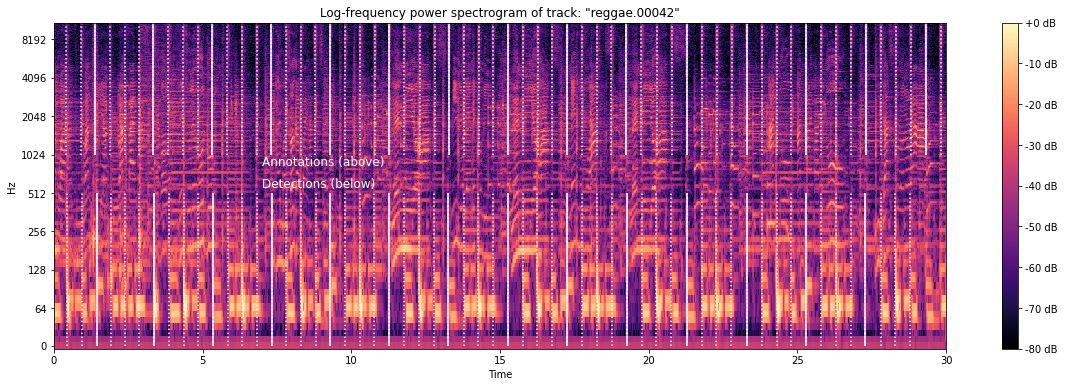

In [36]:
song = test_dataset.track_ids[idx]

det = detections[song]
# print(det)

track = tracks[song]
audio, sr = track.audio
hop_length = 512

spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
# plot annotations in the upper part
plt.vlines(track.beats.times, hop_length * 2, sr / 2, linestyles='dotted', color='w')
plt.vlines(track.beats.times[track.beats.positions == 1], hop_length * 2, sr / 2, color='w')
plt.text(7, hop_length * 1.65, 'Annotations (above)', color='w', fontsize=12)
# plot detections in the lower part
plt.vlines(det['downbeats'][:, 0], 0, hop_length, linestyles='dotted', color='w')
plt.vlines(det['downbeats'][det['downbeats'][:, 1] == 1][:, 0], 0, hop_length, color='w')
plt.text(7, hop_length * 1.1, 'Detections (below)', color='w', fontsize=12)
plt.show()